# MC1 GBSV
## Import

In [1]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.signal import correlate
import pandas as pd
import numpy as np

## Anwendungsfall und Problemstellung

**Problemstellung:**  
Die Temperaturen in der Stadt Basel zeigen über längere Zeiträume wiederkehrende Muster, insbesondere durch saisonale Zyklen. Die Analyse dieser Muster ist entscheidend für verschiedene Anwendungsbereiche, wie Klimaforschung, Energieplanung und landwirtschaftliche Vorhersagen.
In dieser Aufgabe untersuche ich, ob und welche periodischen Muster in den Temperaturdaten von Basel über 10 Jahre bestehen. Ich verwende Auto-Korrelation, um wiederkehrende Zyklen zu identifizieren und zu analysieren.

**Ziel der Analyse:**  
1. Erkennen von periodischen Mustern (z. B. Jahreszeiten) in den Temperaturdaten.
2. Quantitative Bestimmung der Periodizität von Temperaturzyklen.
3. Ableitung von möglichen Langzeittrends oder Anomalien.
4. Demonstration der Auto-Korrelationsanalyse anhand eines ausgewählten Abschnitts der Temperaturdaten.

**Auswahl des 1D-Signals**  
Das Signal, das ich untersuche, sind tägliche Durchschnittstemperaturen aus Basel über einen Zeitraum von 10 Jahren. Dieses Signal ist eindimensional (1D), da es sich um eine Zeitreihe handelt, in der Temperaturwerte über die Zeit gemessen wurden.
Ich erwarte, dass sich saisonale Muster mit einer Periodizität von ungefähr 365 Tagen zeigen, da sich die Jahreszeiten wiederholen. Zudem könnten langfristige Trends wie Klimaerwärmung oder ungewöhnliche Wettereinflüsse sichtbar werden.

## Code zum Abrufen der Temperaturdaten von den letzten 10 Jahren in Basel (Muss nur einmal ausgeführt werden, um die Daten in ein CVS zu speichern)


In [9]:
# Dieser Code kann so von der API kopiert werden
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 47.5584,
    "longitude": 7.5733,
    "start_date": "2015-03-09",
    "end_date": "2025-03-09",
    "daily": "temperature_2m_mean"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

# Konvertiere die Zeit in das Datum ohne Uhrzeit und Zeitzone
start_date = pd.to_datetime(daily.Time(), unit="s", utc=True).normalize()  # Normalize removes the time component
end_date = pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).normalize()  # Normalize removes the time component

# Erstelle die Zeitreihe mit dem gewünschten Format
daily_data = {"date": pd.date_range(
    start=start_date,  # Das erste Datum verwenden
    end=end_date,  # Das Enddatum verwenden
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

daily_dataframe = pd.DataFrame(data=daily_data)

# Speichern der CSV-Datei
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)  # Erstelle den Ordner, falls er nicht existiert
csv_path = os.path.join(output_dir, "weather_data.csv")

daily_dataframe.to_csv(csv_path, index=False)


Coordinates 47.5571174621582°N 7.549342155456543°E
Elevation 283.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s


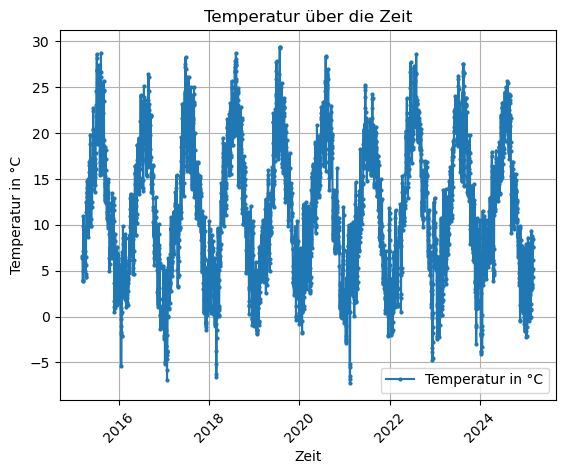

In [85]:
# CSV-Datei laden
csv_path = "C:\\Users\silas\PycharmProjects\GBSV_2025\MC1\Data\weather_data.csv"
if not os.path.exists(csv_path):
    print(f"Fehler: Datei {csv_path} nicht gefunden!")
else:
    daily_dataframe = pd.read_csv(csv_path, parse_dates=["date"])

    # Plot erstellen
    plt.plot(daily_dataframe["date"], daily_dataframe["temperature_2m_mean"], linestyle="-", marker="o", markersize=2, label="Temperatur in °C")

    # Achsentitel und Beschriftungen
    plt.xlabel("Zeit")
    plt.ylabel("Temperatur in °C")
    plt.title("Temperatur über die Zeit")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot anzeigen
    plt.show()

# Autokorrelation- Analysieren der Resultate
Beide Autokorrelationsplots zeigen eine starke oszillierende Struktur. Im Plot über alle 10 Jahre ist zusätzlich eine abnehmende Amplitude ersichtlich, was auf eine periodische Komponente in den Temperaturdaten hinweist. Die Wahl einer hohen Lag-Zahl ist sinnvoll, da sie eine langfristige Analyse ermöglicht und dabei hilft, wiederkehrende Muster wie Jahreszeitenzyklen sichtbar zu machen, weshalb ich eher eine hohe Lag zahl empfehlen würde.
Die allmähliche Abnahme der Autokorrelation zeigt, dass der Einfluss vergangener Temperaturen mit der Zeit schwächer wird, aber regelmässige Schwankungen erhalten bleiben.

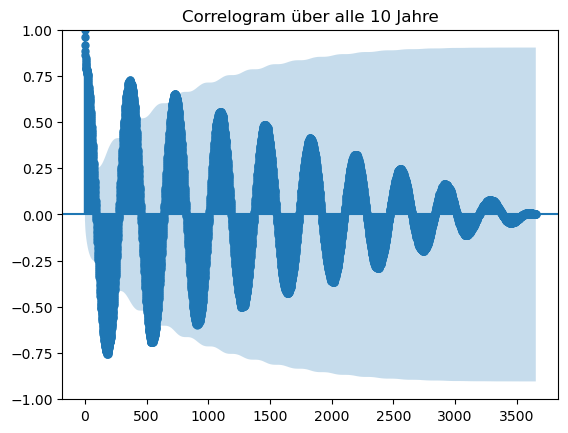

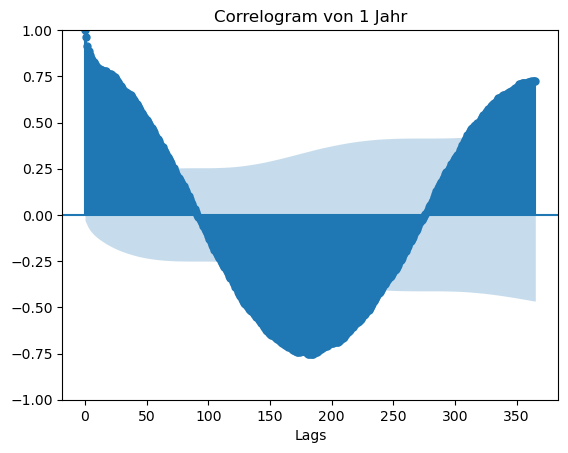

In [11]:
# Überprüfe, ob die Daten korrekt sind und NaN-Werte entfernen
temperature_data = daily_dataframe["temperature_2m_mean"].dropna()

# Bestimme die Anzahl der Lags (Verzögerungen)
lags = len(temperature_data) - 1
lags_1 = 365

# Konvertiere die Daten, falls nötig
temperature_data = temperature_data.to_numpy()

# Plot der Auto-Korrelation
sm.graphics.tsa.plot_acf(temperature_data, lags=lags, title="Correlogram über alle 10 Jahre")
sm.graphics.tsa.plot_acf(temperature_data, lags=lags_1, title="Correlogram von 1 Jahr")

# Achsentitel und Plot anzeigen
plt.xlabel("Lags")
plt.show()

## Kreuzkorrelation - Definition eines Anwendungsfalls für Signal Erkennung
**Problemstellung & Anwendungsfall**

Ein interessantes Anwendungsszenario für die Analyse der Temperaturdaten von Basel ist die Untersuchung der Auswirkungen des Covid-19-Lockdowns auf die lokalen Temperaturen. Der Lockdown führte zu einer erheblichen Reduktion menschlicher Aktivitäten, was möglicherweise messbare Veränderungen in den Temperaturen zur Folge hatte. Das Erkennen solcher Veränderungen kann für verschiedene Anwendungen nützlich sein, z. B. in der Klimaforschung, der Umweltplanung oder der städtischen Entwicklung.

**Auswahl des Teil-Signals & Ziel**

Ich werde die Temperaturdaten vom 16. März 2020 bis zum 30. April 2020 als Teilsignal ausschneiden.

- **Warum diese Wahl?** Dieser Zeitraum umfasst den Beginn und die ersten Wochen des Covid-19-Lockdowns, in dem menschliche Aktivitäten wie Verkehr und Industrieproduktion stark reduziert wurden. Dies bietet eine einzigartige Gelegenheit, die Auswirkungen dieser Reduktion auf die lokalen Temperaturen zu untersuchen.
- **Ziel der Analyse:** Ich möchte prüfen, ob die reduzierte menschliche Aktivität während des Lockdowns zu messbaren Veränderungen in den Temperaturen geführt hat.
- **Erwartung:** Es wird erwartet, dass die Temperaturen während des Lockdowns möglicherweise geringfügige Veränderungen aufweisen, die auf die reduzierte Luftverschmutzung und geringere Wärmeabgabe durch menschliche Aktivitäten zurückzuführen sein könnten.
- **Relevanz:** Die Erkennung und Analyse dieser Veränderungen kann helfen, die Auswirkungen menschlicher Aktivitäten auf das lokale Klima besser zu verstehen und zukünftige Maßnahmen zur Reduzierung der städtischen Erwärmung und zur Verbesserung der Luftqualität zu entwickeln.

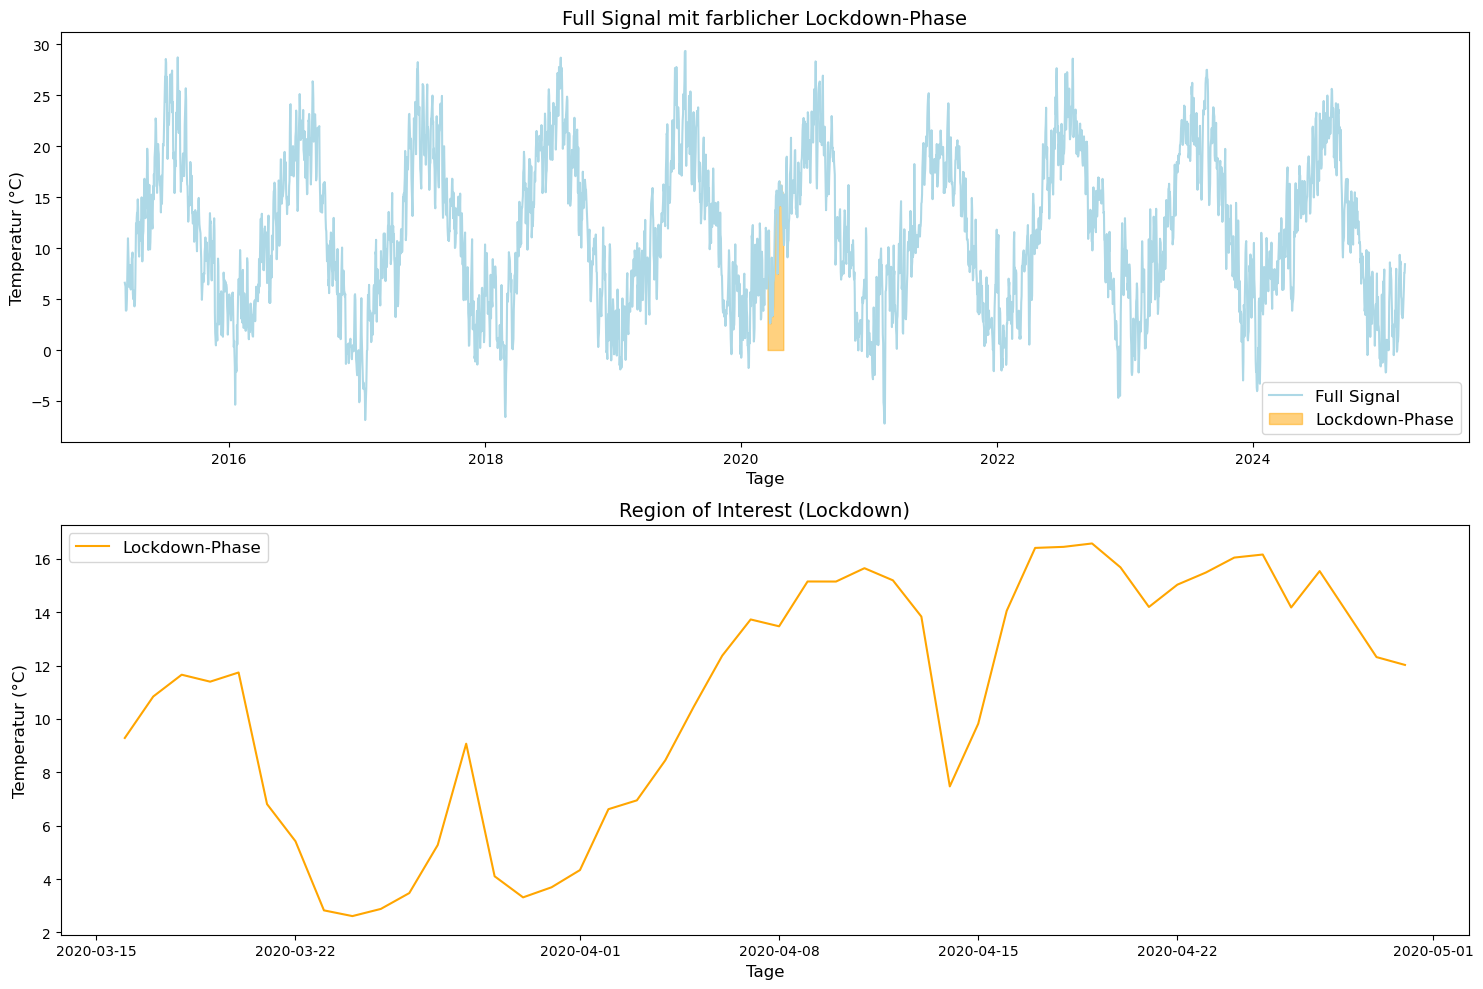

In [46]:
# CSV-Datei laden
df = pd.read_csv(csv_path, parse_dates=["date"])
df.set_index("date", inplace=True)
df = df.dropna(subset=["temperature_2m_mean"])  # Fehlwerte entfernen

# Zeitraum der Lockdown-Phase definieren
lockdown_start = "2020-03-16"
lockdown_end = "2020-04-30"

# Sicherstellen, dass das Zeitfenster existiert
roi = df.loc[lockdown_start:lockdown_end, "temperature_2m_mean"]
full_signal = df["temperature_2m_mean"]

# Kreuzkorrelation berechnen
correlation = correlate(full_signal - np.mean(full_signal), roi - np.mean(roi), mode="full")

# Erstelle die Subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Originaldaten
axs[0].plot(full_signal.index, full_signal, color="lightblue", label="Full Signal")
axs[0].fill_between(roi.index, roi, color="orange", alpha=0.5, label="Lockdown-Phase")  # ROI einfärben
axs[0].set_title("Full Signal mit farblicher Lockdown-Phase", fontsize=14)
axs[0].set_xlabel("Tage", fontsize=12)
axs[0].set_ylabel("Temperatur (°C)", fontsize=12)
axs[0].legend(fontsize=12)

# ROI (Heatwave)
axs[1].plot(roi.index, roi, color="orange", label="Lockdown-Phase")
axs[1].set_title("Region of Interest (Lockdown)", fontsize=14)
axs[1].set_xlabel("Tage", fontsize=12)
axs[1].set_ylabel("Temperatur (°C)", fontsize=12)
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

Die Kreuzkorrelation zwischen dem gesamten Signal und dem definierten Region of Interest (ROI) zeigt den Zeitpunkt mit der höchsten Übereinstimmung, was in meinem Fall das Ende des Lockdowns markiert. Der höchste Korrelationswert tritt am 30.4.2020 auf, was darauf hinweist, dass dieses Segment des Signals am besten mit dem ROI übereinstimmt, und bestätigt somit, dass mein ROI im Datensatz identifiziert wurde.

Index des höchsten Korrelationswerts: 1879
Lag mit der höchsten Korrelation: 1834
Datum des höchsten Lags: 30-04-2020


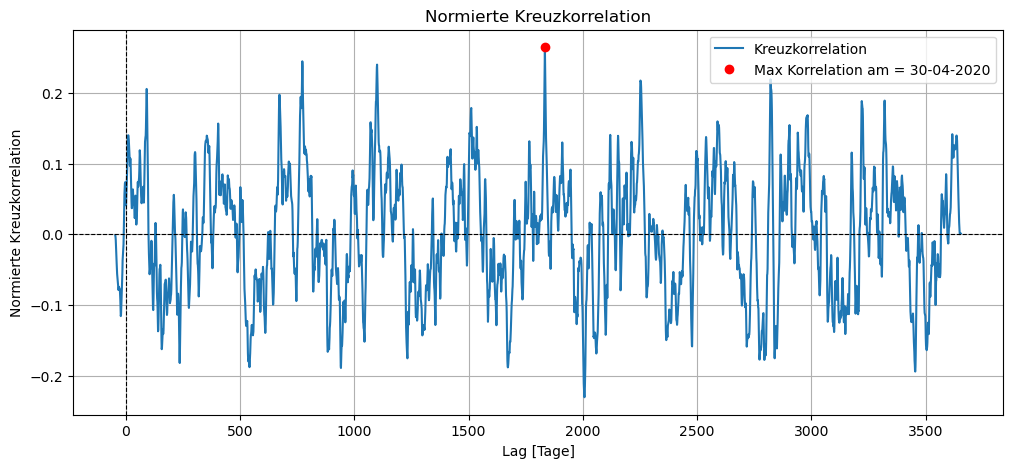

In [80]:
def calculate_cross_correlation(s1, s2, do_normalize=True):
    s1 = np.array(s1).flatten()
    s2 = np.array(s2).flatten()

    # Keine Standardisierung
    if do_normalize:
        s1 = (s1 - np.mean(s1))  # Nur Mittelwertabzug
        s2 = (s2 - np.mean(s2))  # Nur Mittelwertabzug

    corr = np.correlate(s1, s2, mode='full')

    # Falls gewünscht: Normierung auf Signal-Länge
    if do_normalize:
        corr /= len(s1)

    return corr

# Kreuzkorrelation berechnen
cross_corr = calculate_cross_correlation(full_signal, roi)

# Lags erstellen (Zeitenversatz)
lags = np.arange(-len(roi) + 1, len(full_signal))

# Finden des höchsten Korrelationswerts und des zugehörigen Lags
max_index = np.argmax(cross_corr)  # Index des höchsten Korrelationswerts
max_lag = lags[max_index]  # Zugehöriger Lag-Wert
# Datum des höchsten Lags berechnen
lag_date = full_signal.index[max_index]
# Datum ohne Zeit anzeigen
lag_date_formatted = lag_date.strftime('%d-%m-%Y')  # Formatierung des Datums

print("Index des höchsten Korrelationswerts:", max_index)
print("Lag mit der höchsten Korrelation:", max_lag)
print("Datum des höchsten Lags:", lag_date_formatted)

# Plot erstellen
plt.figure(figsize=(12, 5))
plt.plot(lags, cross_corr, linestyle='-', label="Kreuzkorrelation")

# Zusätzliche Linie bei 0 für bessere Sichtbarkeit
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Markiere den höchsten Korrelationswert
plt.plot(max_lag, cross_corr[max_index], 'ro', label=f"Max Korrelation am = {lag_date_formatted}")

# Achsen und Titel
plt.xlabel("Lag [Tage]")
plt.ylabel("Normierte Kreuzkorrelation")
plt.title("Normierte Kreuzkorrelation")
plt.grid(True)
plt.legend()
plt.show()

## 1. Änderung mittels zufälligem Rauschen hinzufügen
**Warum:** Das Hinzufügen von Rauschen kann die Präzision der Kreuzkorrelation verringern, da die Übereinstimmung zwischen den Signalen durch das zufällige Rauschen verzerrt wird. Das Testen mit Rauschen zeigt, wie robust die Methode gegen störende Einflüsse ist.


## 2. Änderung mittels Skalierung
**Warum:** Eine Veränderung der Amplitude des Signals (durch Skalierung) kann ebenfalls getestet werden, um zu sehen, ob die Kreuzkorrelation empfindlich auf solche Transformationen reagiert. Dies hilft zu überprüfen, wie gut das Verfahren bei unterschiedlichen Skalen des Signals funktioniert.

VERRASUCHTES SIGNAL
Max Korrelation für verrauschtes ROI: Index = 1879 
Lag = 1834 
Datum = 30-04-2020

SKALIERTES SIGNAL
Max Korrelation für skaliertes ROI: Index = 1879 
Lag = 1834 
Datum = 30-04-2020


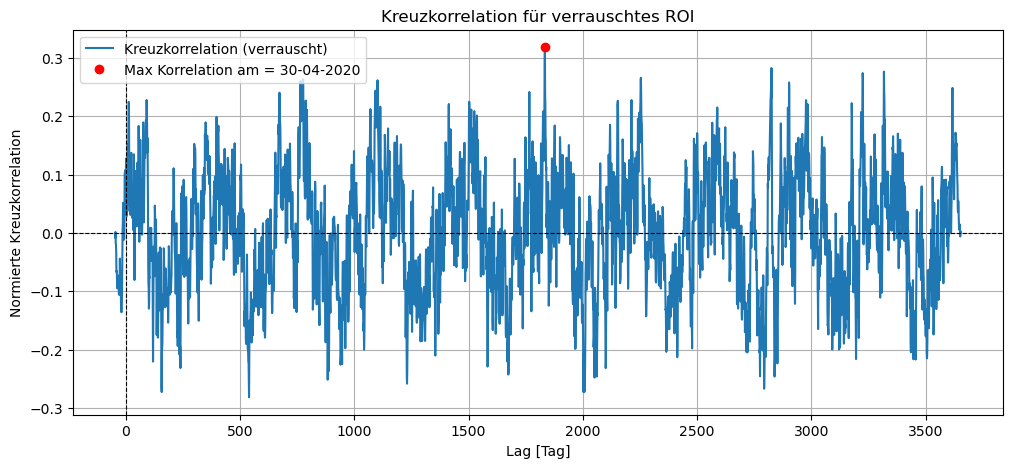

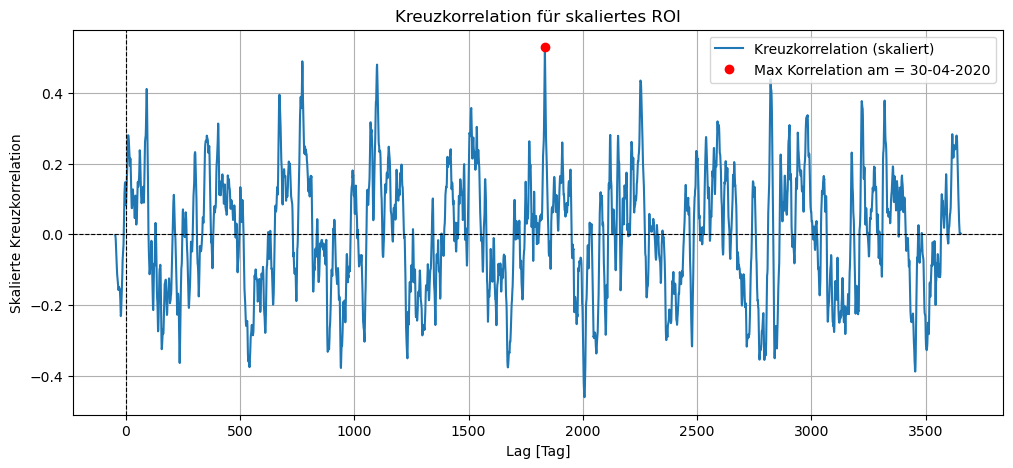

In [102]:
# Hinzufügen von Rauschen zum ROI
noise = np.random.normal(0, 10, len(roi))
noisy_roi = roi + noise

# Skalieren des ROI
scaling_factor = 2
scaled_roi = roi * scaling_factor

# Berechne die Kreuzkorrelation für das verrauschte und skalierte ROI
cross_corr_noisy = calculate_cross_correlation(full_signal, noisy_roi)
cross_corr_scaled = calculate_cross_correlation(full_signal, scaled_roi)

# Lags erstellen (Zeitenversatz)
lags = np.arange(-len(roi) + 1, len(full_signal))

# Finden des höchsten Korrelationswerts und des zugehörigen Lags für das verrauschte Signal
max_index_noisy = np.argmax(cross_corr_noisy)
max_lag_noisy = lags[max_index_noisy]
lag_date_noisy = full_signal.index[max_index_noisy]
lag_date_noisy_formatted = lag_date_noisy.strftime('%d-%m-%Y')  # Formatierung des Datums

print("VERRASUCHTES SIGNAL")
# Ausgabe der Ergebnisse für das verrauschte Signal
print("Max Korrelation für verrauschtes ROI: Index =", max_index_noisy, "\nLag =", max_lag_noisy, "\nDatum =", lag_date_noisy_formatted)

# Finden des höchsten Korrelationswerts und des zugehörigen Lags für das skalierte Signal
max_index_scaled = np.argmax(cross_corr_scaled)
max_lag_scaled = lags[max_index_scaled]
lag_date_scaled = full_signal.index[max_index_scaled]
lag_date_scaled_formatted = lag_date_scaled.strftime('%d-%m-%Y')  # Formatierung des Datums

print("\nSKALIERTES SIGNAL")
# Ausgabe der Ergebnisse für das skalierte Signal
print("Max Korrelation für skaliertes ROI: Index =", max_index_scaled, "\nLag =", max_lag_scaled, "\nDatum =", lag_date_scaled_formatted)

# Plot erstellen für das verrauschte Signal
plt.figure(figsize=(12, 5))
plt.plot(lags, cross_corr_noisy, linestyle='-', label="Kreuzkorrelation (verrauscht)")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Markiere den höchsten Korrelationswert mit einem roten Punkt
plt.plot(max_lag_noisy, cross_corr_noisy[max_index_noisy], 'ro', label=f"Max Korrelation am = {lag_date_noisy_formatted}")

plt.xlabel("Lag [Tag]")
plt.ylabel("Normierte Kreuzkorrelation")
plt.title("Kreuzkorrelation für verrauschtes ROI")
plt.grid(True)
plt.legend()
plt.show()

# Plot erstellen für das skalierte Signal
plt.figure(figsize=(12, 5))
plt.plot(lags, cross_corr_scaled, linestyle='-', label="Kreuzkorrelation (skaliert)")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Markiere den höchsten Korrelationswert mit einem roten Punkt
plt.plot(max_lag_scaled, cross_corr_scaled[max_index_scaled], 'ro', label=f"Max Korrelation am = {lag_date_scaled_formatted}")

plt.xlabel("Lag [Tag]")
plt.ylabel("Skalierte Kreuzkorrelation")
plt.title("Kreuzkorrelation für skaliertes ROI")
plt.grid(True)
plt.legend()
plt.show()

## Kreuzkorrelation Diskussion und Interpretierung

**Wahl der Methoden und Parameter:**
- **Rauschen:** Ich habe zufälliges Rauschen zum ROI hinzugefügt, um die Robustheit der Kreuzkorrelation gegenüber zufälligen Störungen zu testen. Die Wahl eines mittleren Rauschwerts von 0 und einer Standardabweichung von 10 (welches ein grösseres Rauschen bewirkt) dient dazu, den Einfluss von signifikantem Störrauschen zu testen, um zu sehen, ob die Kreuzkorrelation immer noch eine signifikante Übereinstimmung finden kann.
- **Skalierung:** Die Skalierung des ROI mit einem Faktor von 2 dient dazu, den Einfluss der Veränderung der Amplitude zu testen. Diese Art der Transformation ist eine gängige Methode, um zu prüfen, wie gut das Signal mit unterschiedlichen Skalenvariationen im Vergleich zum Originalsignal erkannt wird.

**Beobachtung und Interpretation:**
- **Rauschen:** Beim Hinzufügen von Rauschen bleibt der höchste Korrelationswert zwar noch auffindbar, allerdings verschiebt sich der Zeitpunkt der höchsten Korrelation im Vergleich zum ursprünglichen Zeitraum. Dies zeigt, dass das Rauschen die Genauigkeit der Kreuzkorrelation beeinflusst und das Signal schwieriger zu identifizieren macht. Das Rauschen führt zu einer Verzerrung der Korrelation, was dazu führt, dass das Signal nicht mehr im gleichen Zeitraum wie das ursprüngliche ROI gefunden wird.
- **Skalierung:** Im Falle der Skalierung zeigt sich, dass die Kreuzkorrelation das verschobene ROI am richtigen Ort findet. Auch wenn die Amplitude des ROI verändert wurde, bleibt der Zeitpunkt des höchsten Korrelationswerts unverändert. Das deutet darauf hin, dass die Veränderung der Amplitude keinen Einfluss auf die zeitliche Position des ROI im Signal hat. Diese Art von Transformation hat also weniger Einfluss auf die Korrelation als das Rauschen.

**Was funktioniert und was nicht?**
- **Rauschen:** Das Hinzufügen von Rauschen führt zu einer gewissen Streuung der Werte der Kreuzkorrelation, wodurch das ROI schwieriger zu finden ist. Der höchste Korrelationswert bleibt zwar sichtbar, jedoch ist der Zeitpunkt der höchsten Korrelation verschoben, was darauf hindeutet, dass das Rauschen die genaue Bestimmung des ROI beeinträchtigt. Der Zeitraum des ROI ist daher nicht mehr präzise wie im Originalsignal, was zeigt, dass starkes Rauschen die Genauigkeit und Stabilität der Kreuzkorrelation negativ beeinflusst.
- **Skalierung:** Im Fall der Skalierung funktioniert die Methode gut, da die Kreuzkorrelation das verschobene ROI am richtigen Punkt im Signal findet. Die Veränderung der Amplitude des ROI hat keinen Einfluss auf den Zeitpunkt des höchsten Korrelationswerts, was bedeutet, dass die zeitliche Position des ROI im Signal stabil bleibt. Dies zeigt, dass die Skalierung des ROI im Vergleich zum Rauschen eine weniger störende Veränderung für die Kreuzkorrelation darstellt. Die Skalierung führt daher nicht zu einer Verschiebung des erkannten Zeitpunkts, was diese Transformation robuster gegen Variationen in der Amplitude macht.